In [1]:
import numpy as np
from scipy.stats import special_ortho_group
import jax.numpy as jnp
from jax import grad, vmap
from Mondrian_forest import *
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import pickle

dim_in = 5
active = 2
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = jnp.dot(x, rotation)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = jnp.dot(res ** 4, projected)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 2000
n_test = 1000
tries = 10


x_train, _, x_test, _, _ = pickle.load(open('axis_aligned_data.pickle', 'rb'))

x_train = x_train[:, :dim_in]
x_test = x_test[:, :dim_in]

rotation = np.identity(dim_in)
rotation[1,0] = 1
rotation[2,0] = 1
rotation[3,1] = rotation[4,1] = 1

y_train = simulate_y(x_train, rotation)

y_test = simulate_y(x_test, rotation)

sample_range = [100, 200, 400, 800, 1600]

M = 10                      # number of Mondrian trees to use
delta = 0                   # ridge regression delta

rotation

array([[1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 1.]])

In [2]:
W_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_test, rotation)
from numpy import linalg
true_H = jnp.matmul(jnp.transpose(W_grad), W_grad) / n_test
norm_H = linalg.norm(true_H, ord = 2)

In [3]:
np.set_printoptions(precision=5, suppress=True)
true_H/two_one_norm(true_H)

Array([[0.41535, 0.51755, 0.41535, 0.1022 , 0.1022 ],
       [0.51755, 1.10785, 0.51755, 0.5903 , 0.5903 ],
       [0.41535, 0.51755, 0.41535, 0.1022 , 0.1022 ],
       [0.1022 , 0.5903 , 0.1022 , 0.4881 , 0.4881 ],
       [0.1022 , 0.5903 , 0.1022 , 0.4881 , 0.4881 ]], dtype=float32)

In [4]:
np.linalg.matrix_rank(true_H)

2

In [5]:
def plot_trend(stats, x_axis, y_axis, title, xlabel = None, ylabel = None):
    df = pd.DataFrame(stats)

    # Prepare the data for plotting
    plot_data = [df[y_axis][i] for i in range(len(df))]

    # Create the boxplot
    plt.boxplot(plot_data, labels=[str(x[x_axis]) for x in stats])

    # Add titles and labels
    plt.title(title)
    if xlabel is None:
        xlabel = x_axis
    if ylabel is None:
        ylabel = y_axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Show the plot
    plt.show()

# Save training history

In [6]:
lifetime = 5

stats = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        y_hat_test, history, X_bd_all, w_trees = one_run(
            x_train[:n_sim, ], y_train[:n_sim, ], x_test, M, lifetime, delta
        )
        dist['history'].append([y_hat_test, history, X_bd_all, w_trees])
    stats.append(dist)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


# Get H estimate

In [7]:
def get_H_estimates(stats, x_train, x_test, y_test, M, delta, estimate_H):
    H_est = []
    for i in range(len(sample_range)):
        n_sim = sample_range[i]
        dist = {'n': n_sim, 'mse': [], 'H': []}
        for trial in tqdm(range(tries)):
            y_hat_test, history, X_bd_all, w_trees = \
                stats[i]['history'][trial]
            dist['mse'].append(mean_squared_error(y_test, y_hat_test))
            H_0 = estimate_H(x_train, y_train, X_bd_all, M, x_test, history, w_trees, y_hat_test)
            dist['H'].append(H_0)
        H_est.append(dist)
        
    return H_est

def estimate_H_finite_diff(x_train, y_train, X_bd_all, M, X_test, history, w_trees, y_hat_test):
    dim_in = X_test.shape[1]
    N_test = X_test.shape[0]
    importance = []
    for dim in range(dim_in):
        x_eval_pos = deepcopy(X_test)
        x_eval_neg = deepcopy(X_test)
        x_diff = 0.5
        x_eval_pos[:,dim] = x_eval_pos[:,dim] + x_diff/2
        x_eval_neg[:,dim] = x_eval_neg[:,dim] - x_diff/2
        
        y_eval_pos = evaluate(y_train, x_eval_pos, M, history, w_trees)
        y_eval_neg = evaluate(y_train, x_eval_neg, M, history, w_trees)
        y_diff = y_eval_pos - y_eval_neg
        importance_temp = y_diff/x_diff
        
        importance.append(importance_temp)
    importance = np.vstack(importance)

    H = np.matmul(importance, np.transpose(importance))/N_test
    return H

raw_H_estimates = get_H_estimates(stats, x_train, x_test, y_test, M, delta, estimate_H_finite_diff)

100%|██████████| 10/10 [01:55<00:00, 11.58s/it]


In [8]:
def operator_norm(H, truth):
    norm_truth = norm(truth, ord = 2)
    return norm(truth - H, ord = 2)/norm_truth

def get_eig(A):
    eigenValues, eigenVectors = linalg.eig(A)

    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenVectors

def get_angle_distance(H, truth):
    dim_proj = active
    proj = np.identity(dim_proj)
    proj = np.pad(proj, [(0, dim_in - dim_proj), (0, dim_in - dim_proj)], mode='constant')

    rank = np.linalg.matrix_rank(truth)
    
    eigenvectors = get_eig(H)
    Q_H, _ = linalg.qr(eigenvectors[:, :rank])
    
    eigenvectors = get_eig(truth)
    Q_t, _ = linalg.qr(eigenvectors[:, :rank])

    D = np.matmul(np.transpose(Q_H), Q_t)
    U, S, Vh = np.linalg.svd(D, full_matrices=True)
    S = np.minimum(S, 1)
    return np.max(np.arccos(S))

In [9]:
def plot_dist(H_estimates, title, true_H, norm_H, norm_func):
    plot_data = []
    for i in range(len(sample_range)):
        dist = H_estimates[i]
        n_sim = sample_range[i]
        alter_dist = {'n': n_sim, 'dist':[]}
        for trial in range(tries):
            H_0 = dist['H'][trial]
            alter_dist['dist'].append(norm_func(H_0, true_H))
        plot_data.append(alter_dist)
    try:
        plot_trend(plot_data, 'n', 'dist', title, ylabel='Operator distance from the True H')
    except:
        pass


def plot_H_estimates(raw_H_estimates, true_H, norm_func):

    norm_H = norm(true_H, ord = 2)
    plot_dist(raw_H_estimates, 'Unnormalised', true_H, norm_H, norm_func)

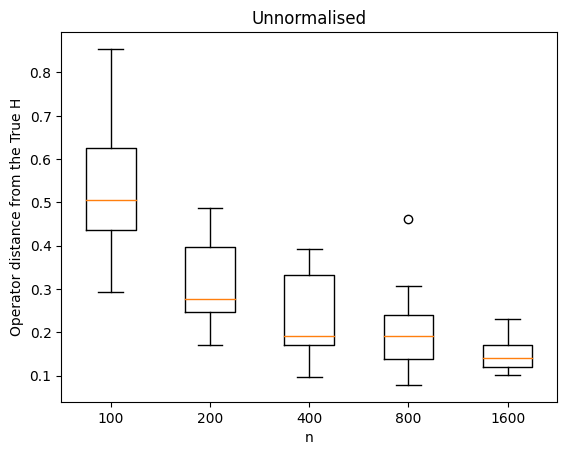

In [10]:
np.set_printoptions(precision=4)
plot_H_estimates(raw_H_estimates, true_H, get_angle_distance)

# Orginal method for estimating gradients

In [11]:
alter_H_estimates = get_H_estimates(stats, x_train, x_test, y_test, M, delta, estimate_H_ind)

100%|██████████| 10/10 [01:09<00:00,  6.92s/it]


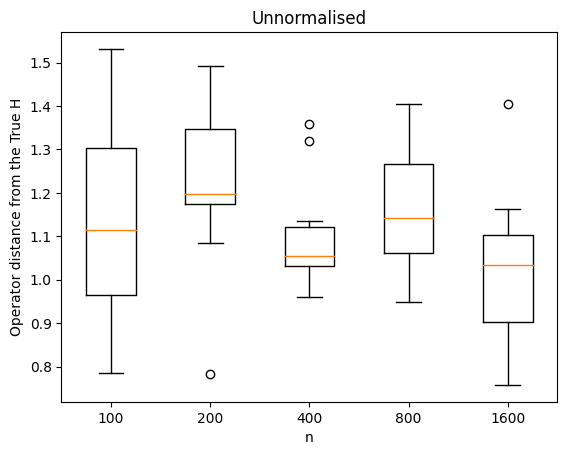

In [12]:
plot_H_estimates(alter_H_estimates, true_H, get_angle_distance)

In [13]:
lifetime_max = 5
n_sim = 1600
results = []
results.append(
    evaluate_all_lifetimes(x_train[:n_sim,], 
                           y_train[:n_sim], 
                           x_test, y_test, M, lifetime_max, delta))

In [14]:
x_train_transformed, x_test_transformed = transform_data(true_H/two_one_norm(true_H), x_train, x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

In [15]:
H_1 = raw_H_estimates[4]['H'][0]/two_one_norm(raw_H_estimates[4]['H'][0])

x_train_transformed, x_test_transformed = transform_data(H_1, x_train, x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

In [16]:
# subset results[0][0]['times'] whose indices mod 10 == 0

def process_times(times):
    return [times[i] for i in range(len(times)) if i % 10 == 0]

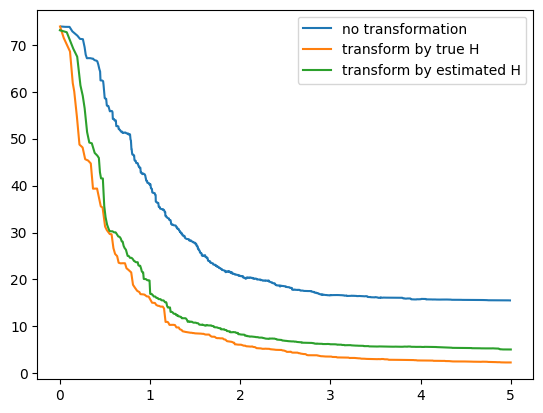

In [17]:
plt.plot(process_times(results[0][0]['times']), results[0][0]['mse'], label = 'no transformation')
plt.plot(process_times(results[1][0]['times']), results[1][0]['mse'], label = 'transform by true H')
plt.plot(process_times(results[2][0]['times']), results[2][0]['mse'], label = 'transform by estimated H')
plt.legend()

In [18]:
raw_H_estimates[4]['H'][0]

array([[ 53.8   ,  36.065 ,  29.7828,  10.7177,  11.034 ],
       [ 36.065 , 103.8562,  40.271 ,  35.634 ,  40.1722],
       [ 29.7828,  40.271 ,  60.0462,  12.0763,  14.4999],
       [ 10.7177,  35.634 ,  12.0763,  52.0026,  28.5319],
       [ 11.034 ,  40.1722,  14.4999,  28.5319,  65.0762]], dtype=float32)

In [19]:
H_1

array([[0.6157, 0.4128, 0.3409, 0.1227, 0.1263],
       [0.4128, 1.1886, 0.4609, 0.4078, 0.4598],
       [0.3409, 0.4609, 0.6872, 0.1382, 0.166 ],
       [0.1227, 0.4078, 0.1382, 0.5952, 0.3265],
       [0.1263, 0.4598, 0.166 , 0.3265, 0.7448]], dtype=float32)

In [20]:
true_H/two_one_norm(true_H)

Array([[0.4154, 0.5176, 0.4154, 0.1022, 0.1022],
       [0.5176, 1.1078, 0.5176, 0.5903, 0.5903],
       [0.4154, 0.5176, 0.4154, 0.1022, 0.1022],
       [0.1022, 0.5903, 0.1022, 0.4881, 0.4881],
       [0.1022, 0.5903, 0.1022, 0.4881, 0.4881]], dtype=float32)

In [21]:
stats = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        y_hat_test, history, X_bd_all, w_trees = one_run(
            x_train_transformed[:n_sim, ], y_train[:n_sim, ], x_test_transformed, M, lifetime, delta
        )
        dist['history'].append([y_hat_test, history, X_bd_all, w_trees])
    stats.append(dist)

100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


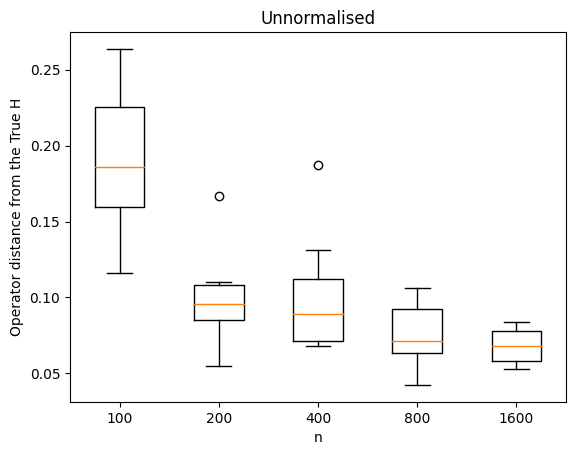

In [22]:
raw_H_estimates = get_H_estimates(stats, x_train_transformed, x_test_transformed, y_test, M, delta, estimate_H_finite_diff)

def get_angle_distance_1(H, truth):
    return get_angle_distance(np.matmul(H_1, H), truth)

plot_H_estimates(raw_H_estimates, true_H, get_angle_distance_1)

In [23]:
H_2 = raw_H_estimates[4]['H'][0]/two_one_norm(raw_H_estimates[4]['H'][0])

x_train_transformed, x_test_transformed = transform_data(H_2, 
                                                         x_train_transformed, x_test_transformed)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

In [24]:
H_12 = np.matmul(H_1, H_2)
H_12

array([[ 0.4928,  0.6609,  0.6059,  0.0935,  0.056 ],
       [ 0.5002,  1.5193,  0.6262,  0.841 ,  0.637 ],
       [ 0.5233,  0.7537,  0.7655,  0.0844,  0.0519],
       [ 0.0276,  0.7451, -0.0197,  0.78  ,  0.5873],
       [ 0.0369,  0.8039, -0.0047,  0.7996,  0.6958]], dtype=float32)

In [25]:
true_H/two_one_norm(true_H)

Array([[0.4154, 0.5176, 0.4154, 0.1022, 0.1022],
       [0.5176, 1.1078, 0.5176, 0.5903, 0.5903],
       [0.4154, 0.5176, 0.4154, 0.1022, 0.1022],
       [0.1022, 0.5903, 0.1022, 0.4881, 0.4881],
       [0.1022, 0.5903, 0.1022, 0.4881, 0.4881]], dtype=float32)

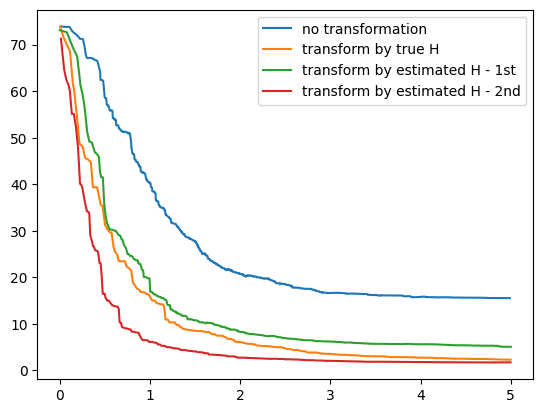

In [26]:
plt.plot(process_times(results[0][0]['times']), results[0][0]['mse'], label = 'no transformation')
plt.plot(process_times(results[1][0]['times']), results[1][0]['mse'], label = 'transform by true H')
plt.plot(process_times(results[2][0]['times']), results[2][0]['mse'], label = 'transform by estimated H - 1st')
plt.plot(process_times(results[3][0]['times']), results[3][0]['mse'], label = 'transform by estimated H - 2nd')
plt.legend()

In [27]:
stats = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        y_hat_test, history, X_bd_all, w_trees = one_run(
            x_train_transformed[:n_sim, ], y_train[:n_sim, ], x_test_transformed, M, lifetime, delta
        )
        dist['history'].append([y_hat_test, history, X_bd_all, w_trees])
    stats.append(dist)

100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


100%|██████████| 10/10 [00:35<00:00,  3.50s/it]


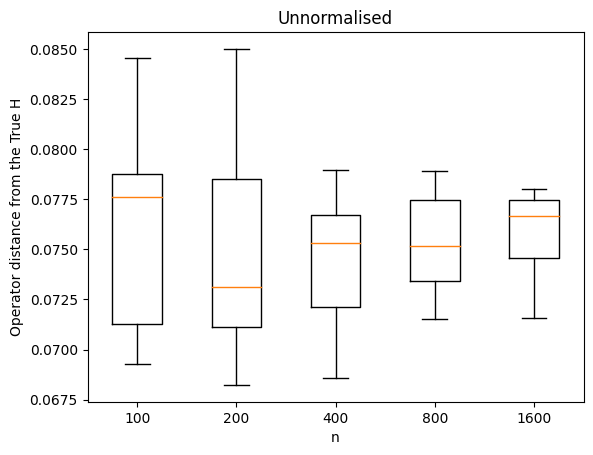

In [28]:
raw_H_estimates = get_H_estimates(stats, x_train_transformed, x_test_transformed, y_test, M, delta, estimate_H_finite_diff)

def get_angle_distance(H, truth):
    dim_proj = active
    proj = np.identity(dim_proj)
    proj = np.pad(proj, [(0, dim_in - dim_proj), (0, dim_in - dim_proj)], mode='constant')

    rank = np.linalg.matrix_rank(truth)
    
    eigenvectors = get_eig(H)
    Q_H, _ = linalg.qr(eigenvectors[:, :rank])
    
    eigenvectors = get_eig(truth)
    Q_t, _ = linalg.qr(eigenvectors[:, :rank])

    D = np.matmul(np.transpose(Q_H), Q_t)
    U, S, Vh = np.linalg.svd(D, full_matrices=True)
    S = np.minimum(S, 1)
    return np.max(np.arccos(S))

def get_angle_distance_12(H, truth):
    return get_angle_distance(np.matmul(H_12, H), truth)

plot_H_estimates(raw_H_estimates, true_H, get_angle_distance_12)

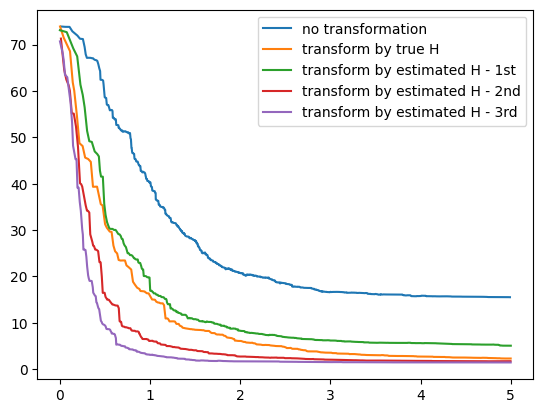

In [29]:
H_3 = raw_H_estimates[4]['H'][0]/two_one_norm(raw_H_estimates[4]['H'][0])
x_train_transformed, x_test_transformed = transform_data(H_3, 
                                                         x_train_transformed, x_test_transformed)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

plt.plot(process_times(results[0][0]['times']), results[0][0]['mse'], label = 'no transformation')
plt.plot(process_times(results[1][0]['times']), results[1][0]['mse'], label = 'transform by true H')
plt.plot(process_times(results[2][0]['times']), results[2][0]['mse'], label = 'transform by estimated H - 1st')
plt.plot(process_times(results[3][0]['times']), results[3][0]['mse'], label = 'transform by estimated H - 2nd')
plt.plot(process_times(results[4][0]['times']), results[4][0]['mse'], label = 'transform by estimated H - 3rd')
plt.legend()

In [30]:
H_3/two_one_norm(H_3)

array([[ 0.664 ,  0.2694,  0.5981, -0.1556, -0.1821],
       [ 0.2694,  0.541 ,  0.2714,  0.3133,  0.3245],
       [ 0.5981,  0.2714,  0.8173, -0.2657, -0.3122],
       [-0.1556,  0.3133, -0.2657,  0.6535,  0.6168],
       [-0.1821,  0.3245, -0.3122,  0.6168,  0.7831]], dtype=float32)

In [31]:
true_H/two_one_norm(true_H)

Array([[0.4154, 0.5176, 0.4154, 0.1022, 0.1022],
       [0.5176, 1.1078, 0.5176, 0.5903, 0.5903],
       [0.4154, 0.5176, 0.4154, 0.1022, 0.1022],
       [0.1022, 0.5903, 0.1022, 0.4881, 0.4881],
       [0.1022, 0.5903, 0.1022, 0.4881, 0.4881]], dtype=float32)